# Import libraries

In [256]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import display, HTML

# Data preprocessing

## Helper functions

In [257]:
def read_json(file_path):
    '''Reads and returns the JSON file'''
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    return data

In [258]:
def performance_to_df(performance_data):
    '''Converts crawl performance file to dataframe'''
    rows = []
    for website, agents in performance_data.items():
        for agent_name, agent_data in agents.items():
            row = {'website': website, 'agent': agent_name}
            row.update(agent_data)
            rows.append(row)
    return pd.DataFrame(rows)

def leak_results_to_df(leak_results_data):
    '''Converts leak results to dataframe'''
    rows = []
    for site_entry in leak_results_data:
        website = site_entry['website']
        for leak in site_entry['leaks']:
            domain = leak['domain']
            for data in leak['data_leaked']:
                row = {
                    'website': website,
                    'domain': domain,
                    'leaked_value': data['leaked_value'],
                    'leak_method': data['leak_method'],
                    'encoding_or_hash': data['encoding_or_hash'],
                    'timestamp': data['timestamp']
                }
                rows.append(row)
    return pd.DataFrame(rows)

def tracker_domains_to_df(domain_map):
    '''Converts the domain map to dataframe'''
    df_domains = pd.DataFrame.from_dict(domain_map, orient='index')
    df_domains.reset_index(inplace=True)
    df_domains.rename(columns={'index': 'domain'}, inplace=True)
    return df_domains

## Import data

In [259]:
# Import the leakage results
semrush_accept_leaks = read_json("crawl_data/semrush_accept/leak_results.json")
semrush_decline_leaks = read_json("crawl_data/semrush_decline/leak_results.json")

aftership_accept_leaks = read_json("crawl_data/aftership_accept/leak_results.json")
aftership_decline_leaks = read_json("crawl_data/aftership_decline/leak_results.json")

In [260]:
# Import the performance statistics
semrush_accept_performance = read_json("crawl_data/semrush_accept/performance.json")
semrush_decline_performance = read_json("crawl_data/semrush_decline/performance.json")

aftership_accept_performance = read_json("crawl_data/aftership_accept/performance.json")
aftership_decline_performance = read_json("crawl_data/aftership_decline/performance.json")

In [261]:
# Import the crawl evaluations
semrush_accept_evaluation = pd.read_csv("crawl_data/semrush_accept/semrush_accept_evaluation.csv", sep=";")
semrush_decline_evaluation = pd.read_csv("crawl_data/semrush_decline/semrush_decline_evaluation.csv", sep=";")

aftership_accept_evaluation = pd.read_csv("crawl_data/aftership_accept/aftership_accept_evaluation.csv", sep=";")
aftership_decline_evaluation = pd.read_csv("crawl_data/aftership_decline/aftership_decline_evaluation.csv", sep=";")

In [262]:
# Import domain map that contains eTLD + 1 and corresponding entities
domain_map = read_json("domain_map.json")

In [263]:
# Import user data that was used during the crawls
user_data = read_json("crawl_data/aftership_accept/user_data.json")

## Convert to dataframes

In [264]:
# Convert performance data
df_semrush_accept_performance = performance_to_df(semrush_accept_performance)
df_semrush_decline_performance = performance_to_df(semrush_decline_performance)

df_aftership_accept_performance = performance_to_df(aftership_accept_performance)
df_aftership_decline_performance = performance_to_df(aftership_decline_performance)

# Convert leak results
df_semrush_accept_leaks = leak_results_to_df(semrush_accept_leaks)
df_semrush_decline_leaks = leak_results_to_df(semrush_decline_leaks)

df_aftership_accept_leaks = leak_results_to_df(aftership_accept_leaks)
df_aftership_decline_leaks = leak_results_to_df(aftership_decline_leaks)

# Convert domain map
df_tracker_domains = tracker_domains_to_df(domain_map)

### Combine dataframes for easier iteration later on

In [265]:
leak_dictionary = {
    "Semrush Accept": df_semrush_accept_leaks,
    "Semrush Decline": df_semrush_decline_leaks,
    "Aftership Accept": df_aftership_accept_leaks,
    "Aftership Decline": df_aftership_decline_leaks
}

performance_dictionary = {
    "Semrush Accept": df_semrush_accept_performance,
    "Semrush Decline": df_semrush_decline_performance,
    "Aftership Accept": df_aftership_accept_performance,
    "Aftership Decline": df_aftership_decline_performance
}

evaluation_dictionary = {
    "Semrush Accept": semrush_accept_evaluation,
    "Semrush Decline": semrush_decline_evaluation,
    "Aftership Accept": aftership_accept_evaluation,
    "Aftership Decline": aftership_decline_evaluation
}

### Remove first party and non-tracker third party domain leaks from dataframes

In [266]:
known_tracker_domains = df_tracker_domains['domain'].unique().tolist()

leak_filtered_dictionary = {}

for key, df in leak_dictionary.items():
    filtered_df = df[
        (df['domain'].isin(known_tracker_domains)) &
        (df['domain'] != df['website'])
    ]
    leak_filtered_dictionary[key] = filtered_df


### Add leak category

In [267]:
categories = {
    "gender": user_data["general"].get("gender"),
    "first_name": user_data["general"].get("first_name"),
    "last_name": user_data["general"].get("last_name"),
    "full_name": f"{user_data['general'].get('first_name')} {user_data['general'].get('last_name')}",
    "email": f"@{user_data['general']['email_suffix']}",
    "password": user_data['general']['password'],
    "phone_number": [profile['local_format'] for profile in user_data['profile'].values()] + 
                [profile['international_format'] for profile in user_data['profile'].values()] +
                [profile['international_format'][1:] for profile in user_data['profile'].values()],
    "country_code": [profile['country_code'] for profile in user_data['profile'].values()],
    "credit_card_number": [
        user_data["general"].get("credit_card_number"),
        user_data["general"].get("credit_card_number").replace(" ", "")
    ],
    "credit_card_expiry": f"{user_data['general']['credit_card_expiry_month']}/{user_data['general']['credit_card_expiry_year']}",
    "street": [profile['street'] for profile in user_data['profile'].values()],
    "zip_code": [re.sub(r'\D', '', profile['zip_code']) for profile in user_data['profile'].values()],
    "city": [profile['city'] for profile in user_data['profile'].values()],
    "province": [profile['province'] for profile in user_data['profile'].values()],
    "country": [profile['country'] for profile in user_data['profile'].values()]
}

In [268]:
def categorize_leaked_value(leaked_value, categories):
    """Categorizes a value into one of the leak categories"""
    if leaked_value.lower().endswith(categories["email"].lower()):
        return "email"

    for category, values in categories.items():
        if category == "email":
            continue

        if isinstance(values, list):
            for val in values:
                if val and re.search(re.escape(val), leaked_value, re.IGNORECASE):
                    return category
        elif isinstance(values, str):
            if values and re.search(re.escape(values), leaked_value, re.IGNORECASE):
                return category

    return "unknown"

In [269]:
for key, df in leak_filtered_dictionary.items():
    df.loc[:, "category"] = df["leaked_value"].apply(lambda x: categorize_leaked_value(x, categories))

C:\Users\Jesmer\AppData\Local\Temp/ipykernel_33956/2793264075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "category"] = df["leaked_value"].apply(lambda x: categorize_leaked_value(x, categories))
C:\Users\Jesmer\AppData\Local\Temp/ipykernel_33956/2793264075.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "category"] = df["leaked_value"].apply(lambda x: categorize_leaked_value(x, categories))
C:\Users\Jesmer\AppData\Local\Temp/ipykernel_33956/2793264075.py:2: SettingWithCopyWar

# Personal data exfiltration

## Helper functions

In [270]:
def calculate_leakage_by_category(df_leaks_filtered, group_by, is_sender=True):
    """
    Computes the leakage occurences by leakage category.
    For sources we count each website group pair only once.
    For endpoints we count each domain group pair only once.
    """
    if is_sender:
        df_leaks_filtered = df_leaks_filtered.drop_duplicates(subset=['website', group_by])
        total_entities = df_leaks_filtered['website'].nunique()
    else:
        df_leaks_filtered = df_leaks_filtered.drop_duplicates(subset=['domain', group_by])
        total_entities = df_leaks_filtered['domain'].nunique()

    leakage_counts = df_leaks_filtered.groupby(group_by).size().reset_index(name='count')
    leakage_counts['percentage'] = (leakage_counts['count'] / total_entities) * 100

    return leakage_counts


In [271]:
def display_leakage_tables(leak_dict, calculation_func, title):
    """
    Displays leakage tables for each crawl in the dictionary
    """
    html_sections = []

    for label, df in leak_dict.items():
        table = calculation_func(df).to_html(index=False)
        section = f"""
        <div style="flex: 1; min-width: 300px; text-align: center;">
            <h4>{label}</h4>
            <div style="display: inline-block; text-align: left;">
                {table}
            </div>
        </div>
        """
        html_sections.append(section)

    combined_html = f"""
    <div style="margin-bottom: 1em;">
        <h3 style="text-align: center;">{title}</h3>
    </div>
    <div style="display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;">
        {''.join(html_sections)}
    </div>
    """
    display(HTML(combined_html))

## Most common tracker domains

In [272]:
def get_tracker_domains(df_leaks_filtered, df_tracker_domains):
    unique_pairs = df_leaks_filtered[['website', 'domain']].drop_duplicates()

    domain_counts = (
        unique_pairs
        .groupby('domain')
        .size()
        .reset_index(name='website_count')
    )

    merged = domain_counts.merge(df_tracker_domains[['domain', 'entityName']], on='domain', how='left')
    grouped = merged.groupby(['entityName', 'domain']).agg(
        website_count=('website_count', 'sum')
    ).reset_index()

    def format_domains(group):
        if len(group) == 1:
            return group['domain'].iloc[0]
        else:
            return ', '.join(f"{row['domain']} ({row['website_count']})" for _, row in group.iterrows())

    result = (
        grouped
        .groupby('entityName')
        .apply(format_domains)
        .reset_index(name='domains_with_counts')
    )

    total_counts = grouped.groupby('entityName')['website_count'].sum().reset_index(name='total_website_count')

    result = result.merge(total_counts, on='entityName')
    result = result.sort_values(by='total_website_count', ascending=False).reset_index(drop=True)

    return result


In [273]:
tracker_domains_dictionary = {}

for key, df in leak_filtered_dictionary.items():
    tracker_domains_dictionary[key] = get_tracker_domains(df, df_tracker_domains)

In [274]:
html_sections = []
for key, df in tracker_domains_dictionary.items():
    html = df.to_html(index=False)
    section = f"""
    <div style="flex: 1;">
        <h4 style='text-align: center;'>{key}</h4>
        {html}
    </div>
    """
    html_sections.append(section)

combined_tracker_html = f"""
<div style="display: flex; flex-wrap: wrap; gap: 20px;">
    {''.join(html_sections)}
</div>
"""

display(HTML(combined_tracker_html))

entityName,domains_with_counts,total_website_count
Google LLC,"doubleclick.net (13), google-analytics.com (5), google.com (18), google.nl (14), googleadservices.com (5), googleapis.com (7), googlesyndication.com (2)",64
"Facebook, Inc.",facebook.com,31
ByteDance Ltd.,tiktok.com,26
Snap Inc.,snapchat.com,17
"Pinterest, Inc.",pinterest.com,14
Microsoft Corporation,"bing.com (11), bing.net (1), clarity.ms (1)",13
"Salesforce.com, Inc.","cquotient.com (1), force.com (1), igodigital.com (5), salesforceliveagent.com (1)",8
"Cloudflare, Inc.",cloudflare.com,6
"Instana, Inc.",instana.io,3
ContentSquare,contentsquare.net,3


## Unique senders and receivers

In [275]:
def calculate_unique_senders_receivers(df):
    """Computes unique senders and receivers"""
    unique_senders = df['website'].nunique()
    unique_receivers = df['domain'].nunique()
    return unique_senders, unique_receivers

In [276]:
summary_rows = []

for key, df in leak_filtered_dictionary.items():
    unique_senders, unique_receivers = calculate_unique_senders_receivers(df)
    summary_rows.append({
        'Dataset': key,
        'Unique Senders': unique_senders,
        'Unique Receivers': unique_receivers
    })

summary_table = pd.DataFrame(summary_rows)

In [277]:
summary_table

,Dataset,Unique Senders,Unique Receivers
0,Semrush Accept,66,46
1,Semrush Decline,35,20
2,Aftership Accept,34,34
3,Aftership Decline,25,37


## Leakage per country

In [278]:
def plot_leaking_websites_by_country(accept_leaks_df, decline_leaks_df, accept_eval_df, decline_eval_df, label=""):
    """ Plots the number of unique leaking websites per country for accept and decline mode"""

    language_to_country = {
        'dutch': 'Netherlands',
        'german': 'Germany',
        'french': 'France',
        'italian': 'Italy',
        'spanish': 'Spain',
        'swedish': 'Sweden'
    }
    
    accept_eval_map = accept_eval_df[['website', 'language']].drop_duplicates()
    decline_eval_map = decline_eval_df[['website', 'language']].drop_duplicates()

    accept_eval_map['country'] = accept_eval_map['language'].map(language_to_country)
    decline_eval_map['country'] = decline_eval_map['language'].map(language_to_country)

    accept_websites = accept_leaks_df['website'].unique()
    decline_websites = decline_leaks_df['website'].unique()

    accept_df = pd.DataFrame(accept_websites, columns=['website']).merge(accept_eval_map, on='website', how='inner')
    decline_df = pd.DataFrame(decline_websites, columns=['website']).merge(decline_eval_map, on='website', how='inner')
    accept_counts = accept_df.groupby('country')['website'].nunique().rename('accept')
    decline_counts = decline_df.groupby('country')['website'].nunique().rename('decline')
    leak_counts = pd.concat([accept_counts, decline_counts], axis=1).fillna(0).astype(int)

    country_order = ['Netherlands', 'Germany', 'France', 'Spain', 'Italy', 'Sweden']
    leak_counts = leak_counts.reindex([c for c in country_order if c in leak_counts.index])

    leak_counts.plot(kind='bar', figsize=(10, 6), color=['green', 'red'])
    title = f'{label}'
    plt.title(title)
    plt.ylabel('Number of sources')
    plt.xlabel('')
    plt.xticks(rotation=360)
    plt.tight_layout()
    plt.show()

def plot_all_leaking_websites_by_country(leak_dict, eval_dict):
    seen_labels = set()

    for key in leak_dict:
        if "Accept" in key:
            label = key.replace(" Accept", "")
            if label in seen_labels:
                continue
            seen_labels.add(label)

            accept_key = f"{label} Accept"
            decline_key = f"{label} Decline"

            accept_leaks_df = leak_dict[accept_key]
            decline_leaks_df = leak_dict[decline_key]
            accept_eval_df = eval_dict[accept_key]
            decline_eval_df = eval_dict[decline_key]

            plot_leaking_websites_by_country(
                accept_leaks_df,
                decline_leaks_df,
                accept_eval_df,
                decline_eval_df,
                label=label
            )


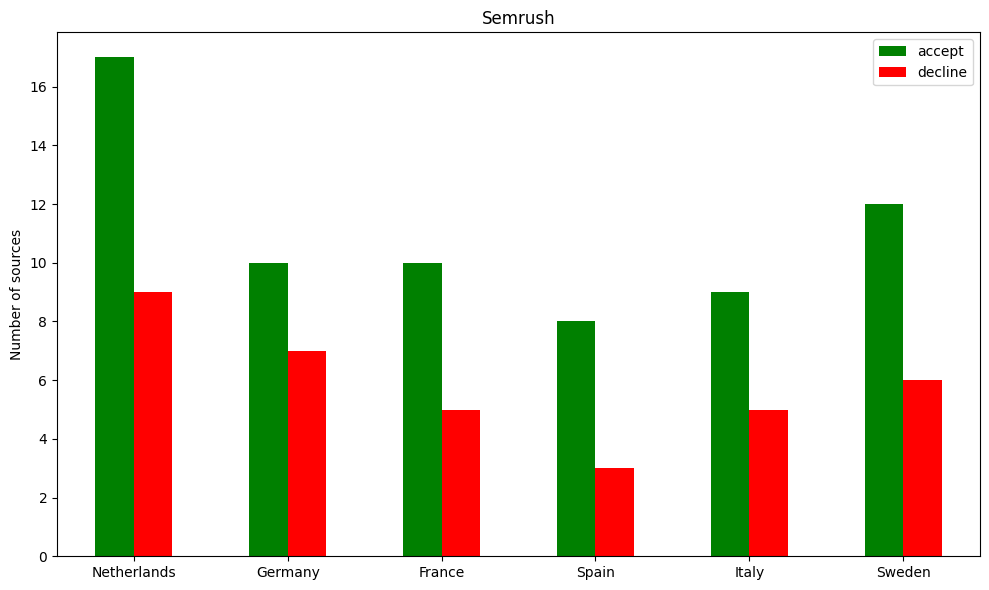

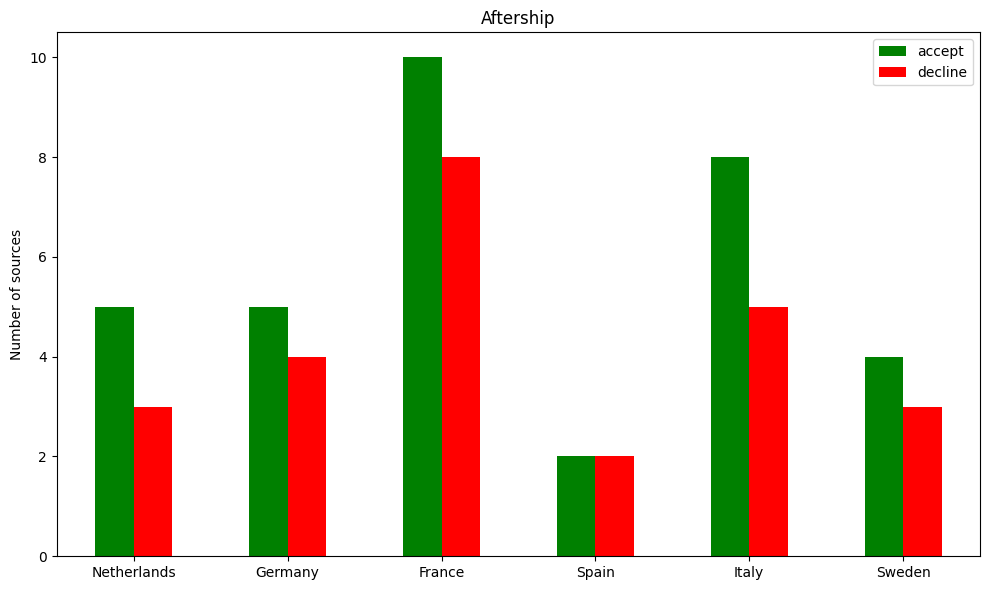

In [279]:
plot_all_leaking_websites_by_country(leak_filtered_dictionary, evaluation_dictionary)


## Type of personal data

In [280]:
def calculate_senders_receivers_category(df):
    """"Computes the amount of unique senders and receivers per personal data category"""

    senders_leakage = calculate_leakage_by_category(df, group_by='category', is_sender=True)
    receivers_leakage = calculate_leakage_by_category(df, group_by='category', is_sender=False)

    leakage_table = pd.merge(senders_leakage, receivers_leakage, on='category', suffixes=('_senders', '_receivers'), how='outer')
    leakage_table = leakage_table.sort_values(by='count_senders', ascending=False)

    leakage_table['senders'] = leakage_table['count_senders'].astype(str) + '/' + leakage_table['percentage_senders'].round(1).astype(str) + '%'
    leakage_table['receivers'] = leakage_table['count_receivers'].astype(str) + '/' + leakage_table['percentage_receivers'].round(1).astype(str) + '%'
    leakage_table_final = leakage_table[['category', 'senders', 'receivers']].reset_index(drop=True)

    return leakage_table_final

In [281]:
display_leakage_tables(leak_filtered_dictionary, calculate_senders_receivers_category, title="Leakage by Category")

category,senders,receivers
email,33/50.0%,19/41.3%
country,26/39.4%,31/67.4%
last_name,16/24.2%,3/6.5%
first_name,15/22.7%,2/4.3%
zip_code,14/21.2%,9/19.6%
city,12/18.2%,6/13.0%
phone_number,10/15.2%,4/8.7%
street,10/15.2%,6/13.0%
country_code,9/13.6%,4/8.7%
gender,8/12.1%,10/21.7%


## Leak method

In [282]:
def calculate_senders_receivers_method(df):
    """"Computes the amount of unique senders and receivers per leak method"""
    senders = calculate_leakage_by_category(df, group_by='leak_method', is_sender=True)
    receivers = calculate_leakage_by_category(df, group_by='leak_method', is_sender=False)

    leakage_table = pd.merge(senders, receivers, on='leak_method', 
                             suffixes=('_senders', '_receivers'), how='outer')
    leakage_table = leakage_table.sort_values(by='count_senders', ascending=False)

    leakage_table['senders'] = leakage_table['count_senders'].astype(str) + '/' + leakage_table['percentage_senders'].round(1).astype(str) + '%'
    leakage_table['receivers'] = leakage_table['count_receivers'].astype(str) + '/' + leakage_table['percentage_receivers'].round(1).astype(str) + '%'

    final_table = leakage_table[['leak_method', 'senders', 'receivers']].reset_index(drop=True)
    return final_table

In [283]:
display_leakage_tables(leak_filtered_dictionary, calculate_senders_receivers_method, title="Leakage by Method")

leak_method,senders,receivers
postData,50/75.8%,14/30.4%
url,50/75.8%,34/73.9%
location,5/7.6%,3/6.5%
referrer,2/3.0%,3/6.5%
setCookie,1/1.5%,1/2.2%
leak_method,senders,receivers
url,27/77.1%,13/65.0%
postData,17/48.6%,9/45.0%
setCookie,1/2.9%,1/5.0%
leak_method,senders,receivers


## Encryption and hashing

In [284]:
def calculate_senders_receivers_encoding(df):
    """"Computes the amount of unique senders and receivers per encoding and hash algorithm"""
    senders = calculate_leakage_by_category(df, group_by='encoding_or_hash', is_sender=True)
    receivers = calculate_leakage_by_category(df, group_by='encoding_or_hash', is_sender=False)

    leakage_table = pd.merge(senders, receivers, on='encoding_or_hash', 
                             suffixes=('_senders', '_receivers'), how='outer')
    leakage_table = leakage_table.sort_values(by='count_senders', ascending=False)

    leakage_table['senders'] = leakage_table['count_senders'].astype(str) + '/' + leakage_table['percentage_senders'].round(1).astype(str) + '%'
    leakage_table['receivers'] = leakage_table['count_receivers'].astype(str) + '/' + leakage_table['percentage_receivers'].round(1).astype(str) + '%'

    final_table = leakage_table[['encoding_or_hash', 'senders', 'receivers']].reset_index(drop=True)
    return final_table


In [285]:
display_leakage_tables(leak_filtered_dictionary, calculate_senders_receivers_encoding, title="Leakage by Encoding")

encoding_or_hash,senders,receivers
urlencode,42/63.6%,38/82.6%
sha256,35/53.0%,9/19.6%
urlencode-sha256,32/48.5%,7/15.2%
custom_map_1,6/9.1%,4/8.7%
custom_map_1-custom_map_1,4/6.1%,2/4.3%
base64,3/4.5%,2/4.3%
sha_salted_1,3/4.5%,1/2.2%
urlencode-base64,3/4.5%,4/8.7%
urlencode-sha_salted_1,3/4.5%,1/2.2%
base64-md5,1/1.5%,1/2.2%


### EC hash websites

In [286]:
google_hash_rows_accept = leak_filtered_dictionary["Aftership Accept"][
    leak_filtered_dictionary["Aftership Accept"]["encoding_or_hash"] == "google_hash"
]

google_hash_rows_accept.head()


,website,domain,leaked_value,leak_method,encoding_or_hash,timestamp,category
277,alyxstudio.com,google.com,piazzale aldo moro,url,google_hash,2025-05-05T17:03:27.094Z,street
278,alyxstudio.com,google.com,david,url,google_hash,2025-05-05T17:03:27.094Z,first_name
279,alyxstudio.com,google.com,lauterbach,url,google_hash,2025-05-05T17:03:27.094Z,last_name
1181,livefastdieyoung.com,googleadservices.com,unter den linden,url,google_hash,2025-05-05T12:15:50.103Z,street
1182,livefastdieyoung.com,googleadservices.com,+49610666475,url,google_hash,2025-05-05T12:15:50.103Z,phone_number


In [287]:
# For Aftership Decline
google_hash_rows_decline = leak_filtered_dictionary["Aftership Decline"][
    leak_filtered_dictionary["Aftership Decline"]["encoding_or_hash"] == "google_hash"
]
google_hash_rows_decline.head()

,website,domain,leaked_value,leak_method,encoding_or_hash,timestamp,category
258,alyxstudio.com,google.com,lauterbach,url,google_hash,2025-05-05T21:56:28.477Z,last_name
259,alyxstudio.com,google.com,david,url,google_hash,2025-05-05T21:56:28.477Z,first_name
260,alyxstudio.com,google.com,piazzale aldo moro,url,google_hash,2025-05-05T21:56:28.477Z,street


## Tracker Entities by identifying categories

In [288]:
def build_entity_leakage_table(df_leaks_filtered, df_tracker_domains, selected_categories):
    df_filtered = df_leaks_filtered[df_leaks_filtered['category'].isin(selected_categories)]
    df_unique = df_filtered[['category', 'website', 'domain']].drop_duplicates()
    df_merged = df_unique.merge(df_tracker_domains[['domain', 'entityName']], on='domain', how='left')

    grouped = (
        df_merged
        .groupby(['category', 'entityName'])
        .agg(num_sites=('website', 'nunique'))
        .reset_index()
        .sort_values(by=['category', 'num_sites'], ascending=[True, False])
    )

    return grouped


In [289]:
def render_grouped_entity_summary_tables(df_grouped):
    categories = df_grouped['category'].unique()
    sections = []

    for category in categories:
        cat_df = df_grouped[df_grouped['category'] == category].copy()
        cat_df = cat_df[['entityName', 'num_sites']]
        cat_df.columns = ['Entity Name', 'Num. Sites']
        cat_df = cat_df.sort_values(by='Num. Sites', ascending=False)
        html_table = cat_df.to_html(index=False, escape=False)

        html_section = f"""
        <div style="flex: 1; min-width: 250px; margin: 10px;">
            <h4 style="font-family: sans-serif; text-align: center;">{category}</h4>
            <div style="overflow-x: auto; padding: 10px; border: 1px solid #ddd; border-radius: 5px;">
                {html_table}
            </div>
        </div>
        """
        sections.append(html_section)

    combined_html = f"""
    <div style="display: flex; flex-wrap: wrap; gap: 20px;">
        {''.join(sections)}
    </div>
    """
    display(HTML(combined_html))


In [290]:
selected_categories = ['email', 'phone_number', 'first_name', 'last_name']

for label, df in leak_filtered_dictionary.items():
    df_grouped = build_entity_leakage_table(df, df_tracker_domains, selected_categories)
    print(f"Entity leakage summary for {label}")
    render_grouped_entity_summary_tables(df_grouped)

Entity leakage summary for Semrush Accept


Entity Name,Num. Sites
"Facebook, Inc.",21
ByteDance Ltd.,12
"Pinterest, Inc.",10
Snap Inc.,5
Awin AG,3
Microsoft Corporation,2
Criteo SA,1
"Datadog, Inc.",1
Dynamic Yield,1
Dynatrace LLC,1


Entity leakage summary for Semrush Decline


Entity Name,Num. Sites
ByteDance Ltd.,4
"Facebook, Inc.",3
Google LLC,1
Microsoft Corporation,1
Postcode Anywhere (Europe) Ltd,1
Snap Inc.,1
Entity Name,Num. Sites
"Facebook, Inc.",1
"WorldPay, Inc.",1
Entity Name,Num. Sites


Entity leakage summary for Aftership Accept


Entity Name,Num. Sites
ByteDance Ltd.,11
"Facebook, Inc.",10
Snap Inc.,6
Criteo SA,3
"Amazon Technologies, Inc.",1
"Mixpanel, Inc.",1
Entity Name,Num. Sites
"Facebook, Inc.",10
Snap Inc.,4
Google LLC,2


Entity leakage summary for Aftership Decline


Entity Name,Num. Sites
"Facebook, Inc.",8
ByteDance Ltd.,2
Snap Inc.,2
"Mixpanel, Inc.",1
Entity Name,Num. Sites
"Facebook, Inc.",9
Google LLC,2
Shopify Inc.,2
Microsoft Corporation,1
"Pinterest, Inc.",1


### Tracker domains

In [291]:
def get_top_tracker_domains(df_leaks_filtered, df_tracker_domains, top_n=10):
    unique_pairs = df_leaks_filtered[['website', 'domain']].drop_duplicates()

    domain_counts = (
        unique_pairs
        .groupby('domain')
        .size()
        .reset_index(name='website_count')
    )

    merged = domain_counts.merge(df_tracker_domains[['domain', 'entityName']], on='domain', how='left')
    top_domains = merged.sort_values(by='website_count', ascending=False).head(top_n).reset_index(drop=True)
    return top_domains


In [292]:
top_tracker_domains = {
    key: get_top_tracker_domains(df, df_tracker_domains)
    for key, df in leak_filtered_dictionary.items()
}

In [293]:
def render_top_tracker_tables(results_dict):
    sections = []

    for title, df in results_dict.items():
        df_display = df[['entityName', 'domain', 'website_count']].copy()
        df_display.columns = ['Entity Name', 'Domain', 'Num. Sites']
        html_table = df_display.to_html(index=False, escape=False)

        html_section = f"""
        <div style="flex: 1; min-width: 300px; margin: 10px; border: 1px solid #ddd; border-radius: 5px; padding: 10px;">
            <h4 style="text-align: center; font-family: sans-serif;">{title}</h4>
            <div style="overflow-x: auto;">
                {html_table}
            </div>
        </div>
        """
        sections.append(html_section)

    combined_html = f"""
    <div style="display: flex; flex-wrap: wrap; gap: 20px;">
        {''.join(sections)}
    </div>
    """

    display(HTML(combined_html))


In [294]:
render_top_tracker_tables(top_tracker_domains)

Entity Name,Domain,Num. Sites
"Facebook, Inc.",facebook.com,31
ByteDance Ltd.,tiktok.com,26
Google LLC,google.com,18
Snap Inc.,snapchat.com,17
"Pinterest, Inc.",pinterest.com,14
Google LLC,google.nl,14
Google LLC,doubleclick.net,13
Microsoft Corporation,bing.com,11
Google LLC,googleapis.com,7
"Cloudflare, Inc.",cloudflare.com,6


# Crawler performance

## Succes rate

In [295]:
agents = ['entry', 'product', 'checkout']
table_data = []

for name, df in evaluation_dictionary.items():
    crawl_row = {"Crawl": name}
    
    for agent in agents:
        pass_count = (df[agent].str.lower() == 'passed').sum()
        crawl_row[agent] = pass_count

    checkout_pass_submit = ((df['checkout'] == 'passed') | (df['checkout'] == 'submit')).sum()  # Count passes + submits in checkout
    pass_submit_partial = ((df['checkout'] == 'passed') | (df['checkout'] == 'submit') | (df['checkout'] == 'partial')).sum()  # Count passes + submits + partials in checkout
    
    crawl_row["checkout (pass + submit)"] = checkout_pass_submit
    crawl_row["Checkout (pass + submit + partial)"] = pass_submit_partial
    table_data.append(crawl_row)

pass_table_df = pd.DataFrame(table_data)
html_table = pass_table_df.to_html(index=False)
display(HTML(html_table))

Crawl,entry,product,checkout,checkout (pass + submit),Checkout (pass + submit + partial)
Semrush Accept,111,86,9,25,73
Semrush Decline,105,75,10,25,67
Aftership Accept,53,49,20,22,49
Aftership Decline,53,48,18,22,48


### Overlapping and unique websites

In [296]:
def get_passed_websites(df):
    return set(df[df['checkout'].str.lower().str.strip() == 'passed']['website'])

from collections import defaultdict

grouped_evaluations = defaultdict(dict)
for key, df in evaluation_dictionary.items():
    source, mode = key.split(' ', 1)
    grouped_evaluations[source][mode] = df

summary_data = []

for source, modes in grouped_evaluations.items():
    passed_accept = get_passed_websites(modes.get('Accept', pd.DataFrame()))
    passed_decline = get_passed_websites(modes.get('Decline', pd.DataFrame()))
    overlap = passed_accept & passed_decline
    union = passed_accept | passed_decline

    summary_data.append({
        "Source": source,
        "Accept Passed": len(passed_accept),
        "Decline Passed": len(passed_decline),
        "Passed in Both": len(overlap),
        "Total Unique Passed": len(union)
    })

summary_df = pd.DataFrame(summary_data)
display(HTML(summary_df.to_html(index=False)))


Source,Accept Passed,Decline Passed,Passed in Both,Total Unique Passed
Semrush,9,10,3,16
Aftership,20,18,9,29


## Failure categories

In [297]:
table_data = []

for name, df in evaluation_dictionary.items():
    failure_counts = df['failure reason'].value_counts().to_dict()
    failure_row = {"Crawl": name}
    for failure, count in failure_counts.items():
        failure_row[failure] = count
    table_data.append(failure_row)

failure_table_df = pd.DataFrame(table_data)
failure_table_df = failure_table_df
html_table = failure_table_df.to_html(index=False, escape=False)

styled_html = f"""
<div style="overflow-x:auto;">
    {html_table}
</div>
"""

display(HTML(styled_html))

Crawl,Selection and interaction failures,Form and input errors,Looping and repetitive actions,Verification and security challenges,Site and navigation issues,Pop-ups and interruptions
Semrush Accept,31,29,16,15.0,14,10
Semrush Decline,38,23,17,11.0,15,8
Aftership Accept,15,11,10,NaN,2,2
Aftership Decline,16,15,6,NaN,4,2


## Cookies performance

In [298]:
cookies_table_data = []

for name, df in evaluation_dictionary.items():
    crawl_row = {"Crawl": name}
    cookies_counts = df['cookies'].value_counts().to_dict()
    
    for cookie_status, count in cookies_counts.items():
        crawl_row[cookie_status] = count

    crawl_row["no dialogue / no choice"] = (cookies_counts.get("no dialogue", 0) + cookies_counts.get("no choice", 0))
    cookies_table_data.append(crawl_row)

cookies_table_df = pd.DataFrame(cookies_table_data)
numeric_cols = cookies_table_df.columns.difference(["Crawl"])
cookies_table_df[numeric_cols] = cookies_table_df[numeric_cols].fillna(0).astype(int)
cookies_table_df = cookies_table_df.drop(columns=[col for col in ['no dialogue', 'no choice'] if col in cookies_table_df.columns])

html_table = cookies_table_df.to_html(index=False)
display(HTML(html_table))


Crawl,passed,failed,no dialogue / no choice,skipped
Semrush Accept,123,4,1,0
Semrush Decline,110,15,1,2
Aftership Accept,50,0,9,1
Aftership Decline,46,3,9,2


## Crawler efficiency

In [299]:
def calculate_and_display_metric(df_dict, metric_name, ordered_agents=None):
    """Computes and shows the average for a given metric"""

    results = {}
    for key, df in df_dict.items():
        results[key] = calculate_average_metric(df, metric_name)
    html_output = ""

    for key, (avg_metric_per_agent, avg_metric_per_website) in results.items():
        title = f"<h3>{key.replace('_', ' ').title()} - Average {metric_name.replace('_', ' ').title()}</h3>"
        
        avg_metric_per_agent = avg_metric_per_agent[['entry_agent', 'product_selection_agent', 'checkout_agent']]
        table = pd.DataFrame({
            'agent': avg_metric_per_agent.index,
            metric_name: avg_metric_per_agent.values
        })

        avg_website_df = pd.DataFrame({
            'agent': ['average_per_website'],
            metric_name: [avg_metric_per_website]
        })

        table = pd.concat([table, avg_website_df], ignore_index=True)

        html_table = table.to_html(index=False)
        html_output += f"<div style='display: inline-block; width: 20%; margin-right: 5%;'>{title}{html_table}</div>"

    display(HTML(html_output))

In [300]:
def calculate_average_metric(df, metric_column):
    """"Computes the average metric of a column"""

    df[metric_column] = pd.to_numeric(df[metric_column], errors='coerce')
    df_filtered = df[df['agent'].isin(['entry_agent', 'product_selection_agent', 'checkout_agent'])]
    avg_metric_per_agent = df_filtered.groupby('agent')[metric_column].mean().round(0).astype(int)
    website_metric_sum = df_filtered.groupby('website')[metric_column].sum()
    avg_metric_per_website = website_metric_sum.mean().round(0).astype(int)

    return avg_metric_per_agent, avg_metric_per_website

### Crawl duration

In [301]:
calculate_and_display_metric(performance_dictionary, 'duration')

agent,duration
entry_agent,41
product_selection_agent,91
checkout_agent,277
average_per_website,308
agent,duration
entry_agent,42
product_selection_agent,91
checkout_agent,261
average_per_website,270
agent,duration


### Token usage

In [302]:
calculate_and_display_metric(performance_dictionary, 'input_tokens')

agent,input_tokens
entry_agent,20973
product_selection_agent,55747
checkout_agent,190227
average_per_website,199046
agent,input_tokens
entry_agent,23924
product_selection_agent,65364
checkout_agent,183805
average_per_website,185482
agent,input_tokens


### Steps

In [303]:
calculate_and_display_metric(performance_dictionary, 'steps_taken')

agent,steps_taken
entry_agent,5
product_selection_agent,9
checkout_agent,23
average_per_website,28
agent,steps_taken
entry_agent,5
product_selection_agent,10
checkout_agent,22
average_per_website,26
agent,steps_taken
